In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

ModuleNotFoundError: No module named 'mplfinance'

# Base class for indicators

In [2]:
class IndicatorBase:
    def __init__(self, df: pd.DataFrame):
        """
        Initializes with a market DataFrame (must include 'Close', 'High', 'Low', 'Volume').
        """
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Expected a pandas DataFrame.")
        required_cols = {"Open", "High", "Low", "Close", "Volume"}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"DataFrame must contain columns: {required_cols}")
        
        self.df = df.copy()

    def compute_indicators(self):
        """Computes common technical indicators and appends them to the DataFrame."""
        self.df["50EMA"] = ta.ema(self.df["Close"], length=50)
        self.df["200EMA"] = ta.ema(self.df["Close"], length=200)
        self.df["RSI"] = ta.rsi(self.df["Close"], length=14)
        self.df["ATR"] = ta.atr(self.df["High"], self.df["Low"], self.df["Close"], length=14)
        self.df["ATR_50"] = self.df["ATR"].rolling(50).mean()

        macd = ta.macd(self.df["Close"], fast=12, slow=26, signal=9)
        self.df["MACD"] = macd["MACD_12_26_9"]
        self.df["Signal"] = macd["MACDs_12_26_9"]
        self.df["MACD_Hist"] = self.df["MACD"] - self.df["Signal"]

        bb = ta.bbands(self.df["Close"], length=20)
        self.df["BB_Upper"] = bb["BBU_20_2.0"]
        self.df["BB_Lower"] = bb["BBL_20_2.0"]
        self.df["BB_Width"] = (self.df["High"].rolling(20).max() - self.df["Low"].rolling(20).min()) / self.df["Close"].rolling(20).mean()

        self.df["OBV"] = (np.sign(self.df["Close"].diff()) * self.df["Volume"]).cumsum()
        self.df["Support"] = self.df["Low"].rolling(20).min()
        self.df["Resistance"] = self.df["High"].rolling(20).max()

        self.df.dropna(inplace=True)
        return self.df

In [3]:
# --- Example usage ---
if __name__ == "__main__":
    # Step 1: Load data
    df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

    # Step 2: Compute indicators
    indicators = IndicatorBase(df)
    df_indicators = indicators.compute_indicators()

In [6]:
df_indicators["RSI"].min()

22.432259412447973

# Price Action

In [7]:
import pandas as pd
import numpy as np

class PriceActionBase:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def compute_candlestick_patterns(self):
        df = self.df

        # Bullish Engulfing
        df['bullish_engulfing'] = ((df['Close'].shift(1) < df['Open'].shift(1)) &
                                   (df['Close'] > df['Open']) &
                                   (df['Close'] > df['Open'].shift(1)) &
                                   (df['Open'] < df['Close'].shift(1)))

        # Bearish Engulfing
        df['bearish_engulfing'] = ((df['Close'].shift(1) > df['Open'].shift(1)) &
                                   (df['Close'] < df['Open']) &
                                   (df['Close'] < df['Open'].shift(1)) &
                                   (df['Open'] > df['Close'].shift(1)))

        # Hammer
        df['hammer'] = ((df['High'] - df['Low']) > 3 * abs(df['Open'] - df['Close'])) & \
                       ((df['Close'] - df['Low']) / (1e-6 + df['High'] - df['Low']) > 0.6) & \
                       ((df['Open'] - df['Low']) / (1e-6 + df['High'] - df['Low']) > 0.6)

        # Doji
        df['doji'] = (abs(df['Close'] - df['Open']) <= (0.1 * (df['High'] - df['Low'])))

        # Inside Bar
        df['inside_bar'] = ((df['High'] < df['High'].shift(1)) &
                            (df['Low'] > df['Low'].shift(1)))

        # Outside Bar (range expansion)
        df['outside_bar'] = ((df['High'] > df['High'].shift(1)) &
                             (df['Low'] < df['Low'].shift(1)))

        # Morning Star (3-bar bullish reversal)
        df['morning_star'] = (
            (df['Close'].shift(2) < df['Open'].shift(2)) &
            (abs(df['Close'].shift(1) - df['Open'].shift(1)) <= 0.3 * (df['High'].shift(1) - df['Low'].shift(1))) &
            (df['Close'] > ((df['Open'].shift(2) + df['Close'].shift(2)) / 2))
        )

        # Evening Star (3-bar bearish reversal)
        df['evening_star'] = (
            (df['Close'].shift(2) > df['Open'].shift(2)) &
            (abs(df['Close'].shift(1) - df['Open'].shift(1)) <= 0.3 * (df['High'].shift(1) - df['Low'].shift(1))) &
            (df['Close'] < ((df['Open'].shift(2) + df['Close'].shift(2)) / 2))
        )

        # Pin Bar (long wick rejection candle)
        df['pin_bar'] = (((df['High'] - df[["Open", "Close"]].max(axis=1)) > 
                          2 * abs(df['Open'] - df['Close'])) |
                         ((df[["Open", "Close"]].min(axis=1) - df['Low']) > 
                          2 * abs(df['Open'] - df['Close'])))

        self.df = df
        return self.df

    def compute_support_resistance(self, window=20):
        df = self.df
        df['local_support'] = df['Low'].rolling(window, center=True).min()
        df['local_resistance'] = df['High'].rolling(window, center=True).max()
        self.df = df
        return self.df

    def compute_context_flags(self, tolerance=0.01):
        """
        Adds context flags such as near support/resistance and big candle.
        """
        df = self.df
        # Price near support/resistance
        df['near_support'] = abs(df['Close'] - df['local_support']) / df['Close'] < tolerance
        df['near_resistance'] = abs(df['Close'] - df['local_resistance']) / df['Close'] < tolerance

        # Big candle: body size compared to rolling average range
        body = abs(df['Close'] - df['Open'])
        range_avg = (df['High'] - df['Low']).rolling(20).mean()
        df['big_candle'] = body > 1.5 * range_avg

        self.df = df
        return self.df

In [8]:
pa = PriceActionBase(df_indicators)

df_indicators_and_price_action = pa.compute_candlestick_patterns()
df_indicators_and_price_action = pa.compute_support_resistance(window=20)
df_indicators_and_price_action = pa.compute_context_flags(tolerance=0.015)

print(df_indicators_and_price_action.tail()[['bullish_engulfing', 'morning_star', 'near_support', 'big_candle']])

                           bullish_engulfing  morning_star  near_support  \
Date                                                                       
2025-03-03 00:00:00+05:30              False         False         False   
2025-03-04 00:00:00+05:30              False         False         False   
2025-03-05 00:00:00+05:30              False         False         False   
2025-03-06 00:00:00+05:30              False         False         False   
2025-03-07 00:00:00+05:30              False         False         False   

                           big_candle  
Date                                   
2025-03-03 00:00:00+05:30       False  
2025-03-04 00:00:00+05:30       False  
2025-03-05 00:00:00+05:30       False  
2025-03-06 00:00:00+05:30       False  
2025-03-07 00:00:00+05:30       False  


# Visualization

In [9]:
def plot_candlestick_with_indicators(df, title="Candlestick with Indicators", window=100, save_path=None):
    df_plot = df.tail(window).copy()
    ohlc = df_plot[["Open", "High", "Low", "Close", "Volume"]].copy()
    apds = []

    panel_counter = 0  # panel 0 = price
    panel_ratios = [2]  # price panel

    # Volume is automatically assigned panel 1 when volume=True
    panel_counter += 1
    panel_ratios.append(0.5)  # smaller height for volume

    # Track additional panel numbers
    rsi_panel = None
    macd_panel = None

    # Add moving averages
    if "50EMA" in df_plot.columns:
        apds.append(mpf.make_addplot(df_plot["50EMA"], panel=0, color="blue", width=1.0))
    if "200EMA" in df_plot.columns:
        apds.append(mpf.make_addplot(df_plot["200EMA"], panel=0, color="purple", width=1.0))

    # Bollinger Bands
    if "BB_Upper" in df_plot.columns and "BB_Lower" in df_plot.columns:
        apds.append(mpf.make_addplot(df_plot["BB_Upper"], panel=0, color="grey", linestyle="--"))
        apds.append(mpf.make_addplot(df_plot["BB_Lower"], panel=0, color="grey", linestyle="--"))

    # RSI (optional panel)
    if "RSI" in df_plot.columns:
        panel_counter += 1
        rsi_panel = panel_counter
        apds.append(mpf.make_addplot(df_plot["RSI"], panel=rsi_panel, color='orange', ylabel='RSI'))
        panel_ratios.append(1)

    # MACD (optional panel)
    if "MACD" in df_plot.columns and "Signal" in df_plot.columns:
        panel_counter += 1
        macd_panel = panel_counter
        apds.append(mpf.make_addplot(df_plot["MACD"], panel=macd_panel, color='green', ylabel='MACD'))
        apds.append(mpf.make_addplot(df_plot["Signal"], panel=macd_panel, color='red'))
        if "MACD_Hist" in df_plot.columns:
            apds.append(mpf.make_addplot(df_plot["MACD_Hist"], panel=macd_panel, type='bar', color='gray', alpha=0.5))
        panel_ratios.append(1)

    # Plot config
    plot_kwargs = dict(
        type='candle',
        style='charles',
        title=title,
        ylabel='Price',
        ylabel_lower='Volume',
        volume=True,
        addplot=apds,
        figscale=1.2,
        figratio=(14, 9),
        panel_ratios=panel_ratios
    )

    if save_path:
        plot_kwargs["savefig"] = save_path

    mpf.plot(ohlc, **plot_kwargs)

    if save_path:
        print(f"Plot saved to {save_path}")


In [10]:
plot_candlestick_with_indicators(df_indicators_and_price_action, save_path="candlestick_price_action_withi_indicators.png")

Plot saved to candlestick_price_action_withi_indicators.png


In [15]:
class PriceActionVisualizer:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def plot(self, window=100, save_path=None):
        df = self.df.tail(window).copy()
        df.index = pd.date_range(end=pd.Timestamp.today(), periods=len(df), freq='B')
        df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])
        df = df.replace([np.inf, -np.inf], np.nan)

        # Convert known pattern flags to boolean
        pattern_cols = ['bullish_engulfing', 'bearish_engulfing', 'hammer', 'doji', 'inside_bar']
        for col in pattern_cols:
            if col in df.columns:
                df[col] = df[col].astype(bool)

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                       gridspec_kw={'height_ratios': [3, 1]})

        # Top: Line chart with markers
        ax1.plot(df.index, df["Close"], label="Close Price", color='black')
        marker_kwargs = dict(markersize=10, linestyle='None')

        if df['bullish_engulfing'].any():
            ax1.plot(df.index[df['bullish_engulfing']], df['Close'][df['bullish_engulfing']],
                     marker='^', color='green', label='Bullish Engulfing', **marker_kwargs)
        if df['bearish_engulfing'].any():
            ax1.plot(df.index[df['bearish_engulfing']], df['Close'][df['bearish_engulfing']],
                     marker='v', color='red', label='Bearish Engulfing', **marker_kwargs)
        if df['hammer'].any():
            ax1.plot(df.index[df['hammer']], df['Close'][df['hammer']],
                     marker='H', color='orange', label='Hammer', **marker_kwargs)
        if df['doji'].any():
            ax1.plot(df.index[df['doji']], df['Close'][df['doji']],
                     marker='.', color='gray', label='Doji', **marker_kwargs)
        if df['inside_bar'].any():
            ax1.plot(df.index[df['inside_bar']], df['Close'][df['inside_bar']],
                     marker='|', color='blue', label='Inside Bar', **marker_kwargs)

        if 'local_support' in df.columns:
            ax1.plot(df.index, df['local_support'], '--', color='green', alpha=0.4, label='Support')
        if 'local_resistance' in df.columns:
            ax1.plot(df.index, df['local_resistance'], '--', color='red', alpha=0.4, label='Resistance')

        ax1.set_title("Close Price with Price Action Patterns")
        ax1.legend()
        ax1.grid(True)

        # Bottom: Candlestick chart
        candle_width = 0.6
        wick_width = 1.5

        for idx, row in df.iterrows():
            color = 'green' if row['Close'] >= row['Open'] else 'red'
            # Wick
            ax2.plot([idx, idx], [row['Low'], row['High']], color='black', linewidth=wick_width)
            # Body
            ax2.add_patch(Rectangle(
                (mdates.date2num(idx) - candle_width / 2, min(row['Open'], row['Close'])),
                candle_width,
                abs(row['Close'] - row['Open']),
                color=color,
                linewidth=0
            ))

        ax2.set_title("Candlestick Chart")
        ax2.grid(True)

        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.xticks(rotation=45)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150)
            print(f"Chart saved to {save_path}")
        # else:
        #     plt.show()

Chart saved to combined_line_and_candle.png


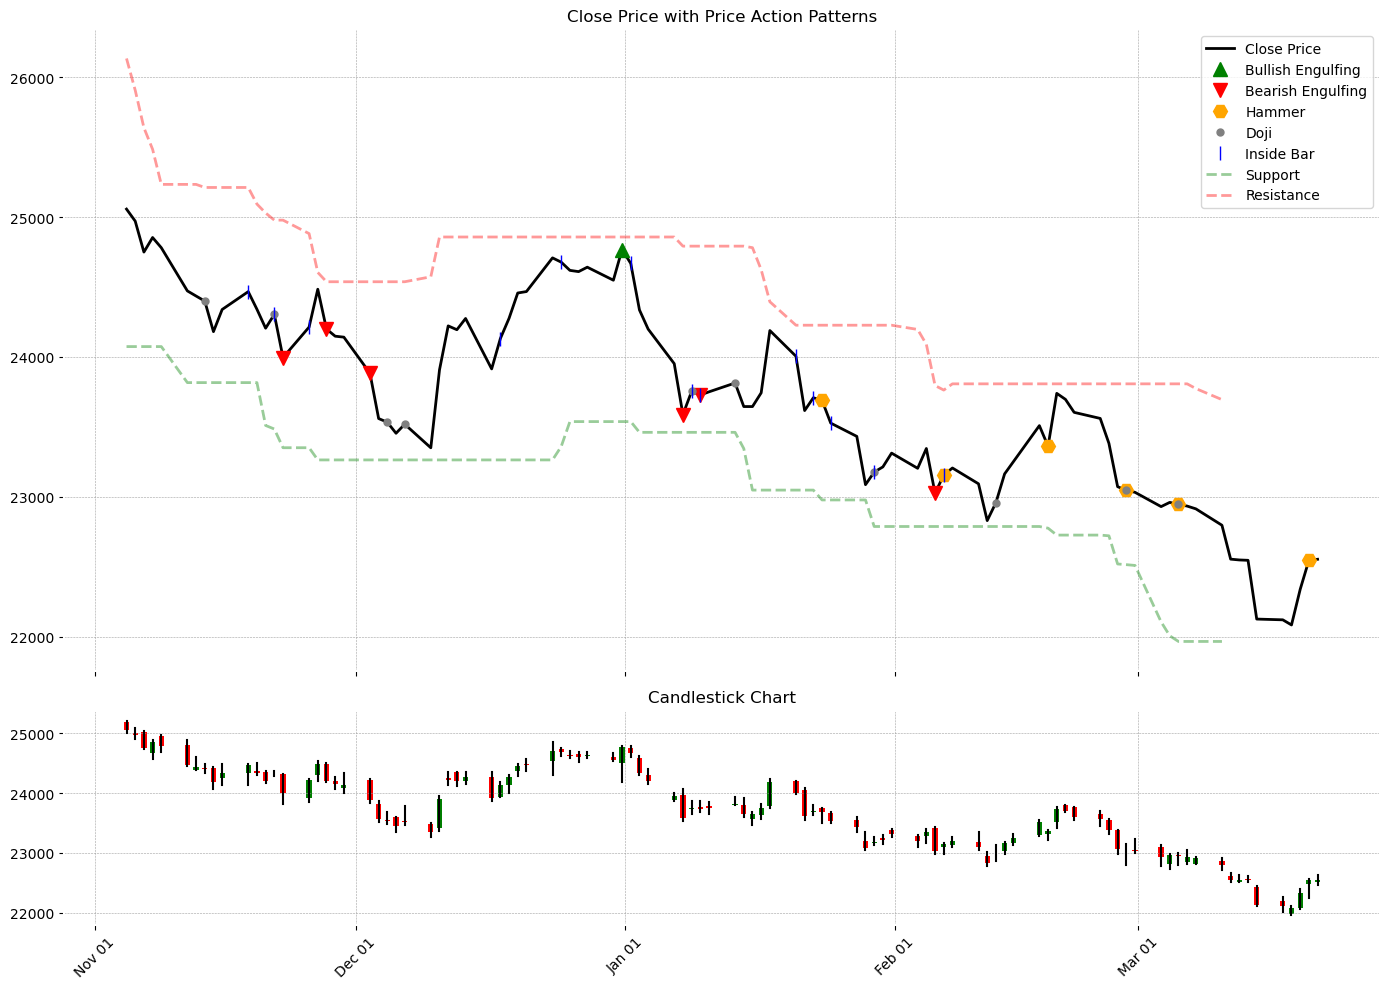

In [16]:

visualizer = PriceActionVisualizer(df_indicators_and_price_action)
visualizer.plot(window=100, save_path="combined_line_and_candle.png")


In [14]:
df_indicators_and_price_action.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       '50EMA', '200EMA', 'RSI', 'ATR', 'ATR_50', 'MACD', 'Signal',
       'MACD_Hist', 'BB_Upper', 'BB_Lower', 'BB_Width', 'OBV', 'Support',
       'Resistance', 'bullish_engulfing', 'bearish_engulfing', 'hammer',
       'doji', 'inside_bar', 'outside_bar', 'morning_star', 'evening_star',
       'pin_bar', 'local_support', 'local_resistance', 'near_support',
       'near_resistance', 'big_candle'],
      dtype='object')